##### Импорт библиотек

In [349]:
import pandas as pd
import numpy as np
import os
import logging
import warnings
import json

import joblib
import xgboost as xgb
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

# Отключаем логи LightGBM
logging.getLogger('lightgbm').setLevel(logging.WARNING)

os.makedirs('models', exist_ok=True)

print("Библиотеки загружены!\n")

Библиотеки загружены!



In [350]:
# УЛУЧШЕННОЕ СОЗДАНИЕ ПРИЗНАКОВ НА ОСНОВЕ EDA БЕЗ УТЕЧЕК
print("Создание УЛУЧШЕННЫХ признаков на основе EDA анализа БЕЗ УТЕЧЕК...")
df = pd.read_csv('df/obr.csv', parse_dates=['datetime'], index_col='datetime')
print(f"Исходный размер: {df.shape}")

# ===== ОСНОВНЫЕ ВРЕМЕННЫЕ ПРИЗНАКИ =====
# Циклические признаки (БЕЗОПАСНЫЕ - нет утечек)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

# ===== ПРИЗНАКИ ИЗ EDA АНАЛИЗА =====
# 1. СУТОЧНЫЕ ПАТТЕРНЫ (из анализа часов) - БЕЗОПАСНЫЕ
df['is_early_morning'] = ((df['hour'] >= 4) & (df['hour'] <= 6)).astype(int)
df['is_midday'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)
df['is_late_evening'] = ((df['hour'] >= 21) & (df['hour'] <= 23)).astype(int)
df['is_evening_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 22)).astype(int)
df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype(int)

# 2. НЕДЕЛЬНЫЕ ПАТТЕРНЫ (из анализа дней) - БЕЗОПАСНЫЕ
df['is_monday'] = (df['day_of_week'] == 0).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)
df['is_sunday'] = (df['day_of_week'] == 6).astype(int)
df['weekend_evening_boost'] = (df['is_weekend'] & df['is_evening_peak']).astype(int)
df['weekend_morning'] = (df['is_weekend'] & df['is_morning_peak']).astype(int)

# 3. МЕСЯЧНЫЕ/СЕЗОННЫЕ ПАТТЕРНЫ (из анализа месяцев) - БЕЗОПАСНЫЕ
df['is_high_season'] = df['month'].isin([1, 2, 12]).astype(int)
df['is_low_season'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)

# 4. КРИТИЧЕСКИЕ ПЕРИОДЫ ИЗ EDA - БЕЗОПАСНЫЕ
df['morning_surge_6_7'] = ((df['hour'] >= 6) & (df['hour'] <= 7)).astype(int)
df['evening_surge_17_18'] = ((df['hour'] >= 17) & (df['hour'] <= 18)).astype(int)
df['evening_drop_22_23'] = ((df['hour'] >= 22) & (df['hour'] <= 23)).astype(int)

# 5. ВЗАИМОДЕЙСТВИЯ ПРИЗНАКОВ НА ОСНОВЕ EDA - БЕЗОПАСНЫЕ
df['winter_evening'] = (df['is_high_season'] & df['is_evening_peak']).astype(int)
df['summer_afternoon'] = (df['is_low_season'] & df['is_midday']).astype(int)
df['workday_evening'] = ((~df['is_weekend']) & df['is_evening_peak']).astype(int)
df['sunday_evening'] = (df['is_sunday'] & df['is_evening_peak']).astype(int)

# ===== УМНЫЕ ЛАГИ НА ОСНОВЕ АВТОКОРРЕЛЯЦИИ =====
# Используем стратегические лаги на основе анализа ACF/PACF - БЕЗОПАСНЫЕ
print("Создание лагов...")
df['lag_same_day_24h'] = df['Global_active_power'].shift(24)        # Вчера в это же время
df['lag_week_ago_168h'] = df['Global_active_power'].shift(24*7)     # Неделю назад в это же время

# ДОБАВЛЯЕМ НУЖНЫЕ ЛАГИ согласно EDA анализу
df['lag_48h_ago'] = df['Global_active_power'].shift(48)             # 2 дня назад
df['lag_72h_ago'] = df['Global_active_power'].shift(72)             # 3 дня назад  
df['lag_96h_ago'] = df['Global_active_power'].shift(96)             # 4 дня назад

# Более детальные периоды из EDA
df['is_sunday_evening'] = ((df['day_of_week'] == 6) & (df['is_evening_peak'])).astype(int)
df['winter_morning_peak'] = ((df['is_high_season']) & (df['is_morning_peak'])).astype(int)
df['summer_afternoon'] = ((df['is_low_season']) & (df['hour'].between(13, 17))).astype(int)

# ===== ВЗАИМОДЕЙСТВИЯ ЛАГОВ С ВРЕМЕННЫМИ ПЕРИОДАМИ =====
# Это заставит модель учитывать КОГДА использовать лаги
print("Создание взаимодействий лагов...")
df['lag_24h_morning'] = df['lag_same_day_24h'] * df['is_morning_peak']
df['lag_24h_evening'] = df['lag_same_day_24h'] * df['is_evening_peak']
df['lag_24h_night'] = df['lag_same_day_24h'] * df['is_night']
df['lag_24h_weekend'] = df['lag_same_day_24h'] * df['is_weekend']

# ТЕПЕРЬ ЭТИ ПРИЗНАКИ БУДУТ РАБОТАТЬ, потому что lag_48h_ago создан
df['lag_48h_morning'] = df['lag_48h_ago'] * df['is_morning_peak']
df['lag_48h_evening'] = df['lag_48h_ago'] * df['is_evening_peak']

df['lag_week_morning'] = df['lag_week_ago_168h'] * df['is_morning_peak']
df['lag_week_evening'] = df['lag_week_ago_168h'] * df['is_evening_peak']

print(f"Создано {len([col for col in df.columns if col not in ['Global_active_power', 'datetime']])} признаков")

# ===== СКОЛЬЗЯЩИЕ СТАТИСТИКИ БЕЗ УТЕЧЕК - ИСПРАВЛЕННЫЕ =====
# ВАЖНО: Двойной сдвиг чтобы использовать ТОЛЬКО ПРОШЛЫЕ данные
print("Создание скользящих статистик БЕЗ утечек...")

# ОСНОВНЫЕ СКОЛЬЗЯЩИЕ СТАТИСТИКИ (согласно EDA - долгосрочные)
df['rolling_mean_24h'] = df['Global_active_power'].shift(1).rolling(24, min_periods=1).mean().shift(1)
df['rolling_mean_168h'] = df['Global_active_power'].shift(1).rolling(168, min_periods=1).mean().shift(1)

# Для 24-часового стандартного отклонения
df['rolling_std_24h_past'] = df['Global_active_power'].shift(1).rolling(window=24, min_periods=1).std().shift(1)

# Для 7-дневного среднего
df['rolling_mean_7d_past'] = df['Global_active_power'].shift(1).rolling(window=24*7, min_periods=1).mean().shift(1)

# ===== ПРИЗНАКИ ИЗ СУБ-СЧЕТЧИКОВ =====
# Относительное потребление по зонам - БЕЗОПАСНЫЕ (текущие измерения)
df['total_sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['kitchen_ratio'] = df['Sub_metering_1'] / (df['total_sub_metering'] + 0.001)
df['laundry_ratio'] = df['Sub_metering_2'] / (df['total_sub_metering'] + 0.001)
df['ac_heating_ratio'] = df['Sub_metering_3'] / (df['total_sub_metering'] + 0.001)

# Активность по зонам (бинарные признаки) - БЕЗОПАСНЫЕ
df['kitchen_active'] = (df['Sub_metering_1'] > 0).astype(int)
df['laundry_active'] = (df['Sub_metering_2'] > 0).astype(int)
df['ac_heating_active'] = (df['Sub_metering_3'] > 0).astype(int)

# ===== ДОПОЛНИТЕЛЬНЫЕ ПРИЗНАКИ ИЗ EDA =====
# Периоды минимального потребления (ночь) - БЕЗОПАСНЫЕ
df['is_deep_night'] = ((df['hour'] >= 1) & (df['hour'] <= 4)).astype(int)

# Дни с особым паттерном - БЕЗОПАСНЫЕ
df['is_week_start'] = (df['day_of_week'].isin([0, 1])).astype(int)
df['is_week_end'] = (df['day_of_week'].isin([4, 5])).astype(int)

# Социальные паттерны
df['is_family_time'] = ((df['hour'] >= 18) & (df['hour'] <= 22) & (df['is_weekend'] == 0)).astype(int)
df['is_weekend_evening'] = (df['is_weekend'] & df['is_evening_peak']).astype(int)

# Поведенческие паттерны  
df['is_meal_prep_time'] = ((df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
df['is_entertainment_time'] = ((df['hour'] >= 20) & (df['hour'] <= 23)).astype(int)

# Добавьте эти признаки - они точно улучшат модель:
df['winter_evening_peak'] = (df['is_high_season'] & df['is_evening_peak']).astype(int)
df['summer_afternoon_ac'] = (df['is_low_season'] & df['is_midday'] & df['ac_heating_active']).astype(int)
df['weekend_morning_kitchen'] = (df['is_weekend'] & df['is_morning_peak'] & df['kitchen_active']).astype(int)

# Взаимодействия лагов с сезонностью
df['lag_24h_winter'] = df['lag_same_day_24h'] * df['is_high_season']
df['lag_168h_weekend'] = df['lag_week_ago_168h'] * df['is_weekend']

# Экстремальные периоды из EDA
df['extreme_evening_peak'] = ((df['hour'] >= 19) & (df['hour'] <= 21)).astype(int)
df['sunday_evening_surge'] = ((df['day_of_week'] == 6) & (df['is_evening_peak'])).astype(int)
df['deep_night_low'] = ((df['hour'] >= 1) & (df['hour'] <= 4)).astype(int)

# Взаимодействия с суб-счетчиками
df['evening_ac_demand'] = df['is_evening_peak'] * df['ac_heating_ratio']
df['morning_kitchen_demand'] = df['is_morning_peak'] * df['kitchen_ratio']

# Зимние вечера + отопление
df['winter_evening_heating'] = (df['is_high_season'] & df['is_evening_peak'] & 
                               (df['ac_heating_ratio'] > 0.3)).astype(int)

# Летние дни + кондиционер  
df['summer_afternoon_cooling'] = (df['is_low_season'] & df['is_midday'] &
                                 (df['ac_heating_ratio'] > 0.4)).astype(int)

print(f"Создано {len([col for col in df.columns if col not in ['Global_active_power', 'datetime']])} признаков")

# ===== ОБРАБОТКА ПРОПУСКОВ =====
print("Обработка пропусков...")
initial_size = len(df)

# Заполняем пропуски в числовых признаках
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df[col].isnull().any():
        # Для лагов и скользящих - заполняем предыдущими значениями
        if 'lag' in col or 'rolling' in col:
            df[col] = df[col].ffill().bfill()
        else:
            df[col] = df[col].fillna(df[col].median())

# Удаляем оставшиеся пропуски
df = df.dropna()

print(f"Признаки созданы. Удалено {initial_size - len(df)} строк с пропусками")
print(f"Финальный размер: {df.shape}")

Создание УЛУЧШЕННЫХ признаков на основе EDA анализа БЕЗ УТЕЧЕК...
Исходный размер: (260640, 14)
Создание лагов...
Создание взаимодействий лагов...
Создано 52 признаков
Создание скользящих статистик БЕЗ утечек...
Создано 82 признаков
Обработка пропусков...
Признаки созданы. Удалено 0 строк с пропусками
Финальный размер: (260640, 83)


In [351]:
df.sample(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,...,weekend_morning_kitchen,lag_24h_winter,lag_168h_weekend,extreme_evening_peak,sunday_evening_surge,deep_night_low,evening_ac_demand,morning_kitchen_demand,winter_evening_heating,summer_afternoon_cooling
datetime,,,,,,,,,,,,,,,,,,,,,
2007-06-19 23:20:00,0.868,0.342,240.05,3.8,0.0,1.0,0.0,23,1,6,...,0,0.0,0.000,0,0,0,0.0,0.0,0,0
2007-03-03 04:34:00,0.216,0.000,242.11,0.8,0.0,0.0,0.0,4,5,3,...,0,0.0,1.468,0,0,1,0.0,0.0,0,0
2007-03-27 05:09:00,0.294,0.094,239.10,1.2,0.0,1.0,0.0,5,1,3,...,0,0.0,0.000,0,0,0,0.0,0.0,0,0
2007-03-06 01:49:00,0.208,0.000,243.19,0.8,0.0,0.0,0.0,1,1,3,...,0,0.0,0.000,0,0,1,0.0,0.0,0,0
2007-05-04 22:06:00,1.460,0.094,236.26,6.2,0.0,0.0,0.0,22,4,5,...,0,0.0,0.000,0,0,0,0.0,0.0,0,0


In [352]:
# ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ БЕЗ УТЕЧЕК
print("Подготовка данных БЕЗ утечек...")

# Целевая переменная
y = df['Global_active_power']

# ОПТИМАЛЬНЫЙ СПИСОК ПРИЗНАКОВ НА ОСНОВЕ EDA И ИСПРАВЛЕНИЙ
optimal_features = [
    # === ЦИКЛИЧЕСКИЕ ПРИЗНАКИ ===
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
    
    # === СУТОЧНЫЕ ПАТТЕРНЫ ИЗ EDA ===
    'is_early_morning', 'is_midday', 'is_late_evening',
    'is_evening_peak', 'is_morning_peak', 'is_night', 'is_deep_night',
    
    # === НЕДЕЛЬНЫЕ ПАТТЕРНЫ ИЗ EDA ===
    'is_monday', 'is_friday', 'is_sunday', 
    'is_week_start', 'is_week_end',
    'weekend_evening_boost', 'weekend_morning',
    
    # === СЕЗОННЫЕ ПАТТЕРНЫ ИЗ EDA ===
    'is_high_season', 'is_low_season', 'is_spring',
    
    # === КРИТИЧЕСКИЕ ПЕРИОДЫ ИЗ EDA ===
    'morning_surge_6_7', 'evening_surge_17_18', 'evening_drop_22_23',
    
    # === ВЗАИМОДЕЙСТВИЯ ПРИЗНАКОВ ===
    'winter_evening', 'summer_afternoon', 'workday_evening', 'sunday_evening',
    
    # === ДОЛГОСРОЧНЫЕ ЛАГИ (согласно EDA - 3 дня памяти) ===
    'lag_same_day_24h', 'lag_week_ago_168h',
    'lag_48h_ago', 'lag_72h_ago', 'lag_96h_ago',
    
    # === ВЗАИМОДЕЙСТВИЯ ЛАГОВ ===
    'lag_24h_morning', 'lag_24h_evening', 'lag_24h_night', 'lag_24h_weekend',
    'lag_48h_morning', 'lag_48h_evening',
    'lag_week_morning', 'lag_week_evening',
    
    # === СКОЛЬЗЯЩИЕ СТАТИСТИКИ (долгосрочные согласно EDA) ===
    'rolling_mean_24h', 'rolling_mean_168h',  # Новые долгосрочные статистики
    'rolling_mean_24h_past', 'rolling_mean_7d_past',
    
    # === ОСЛАБЛЕННЫЕ КОРОТКИЕ СТАТИСТИКИ ===
    'rolling_mean_3h_past',  # Ослабленное влияние
    
    # === ПРИЗНАКИ ИЗ СУБ-СЧЕТЧИКОВ ===
    'kitchen_ratio', 'laundry_ratio', 'ac_heating_ratio',
    'kitchen_active', 'laundry_active', 'ac_heating_active',
    
    # === БАЗОВЫЕ ВРЕМЕННЫЕ ПРИЗНАКИ ===
    'hour', 'day_of_week', 'month', 'is_weekend'
]

# Исключаем доминирующий признак
features_fixed = [f for f in optimal_features if f != 'rolling_mean_3h_past']

print(f"Было: {len(optimal_features)} признаков")
print(f"Стало: {len(features_fixed)} признаков")

# АЛЬТЕРНАТИВНЫЙ ВАРИАНТ: БЕЗ ДОМИНИРУЮЩЕГО ПРИЗНАКА
features_without_dominant = [f for f in optimal_features if f != 'rolling_mean_3h_past']

# ДОБАВЛЯЕМ НОВЫЕ ПРИЗНАКИ В СПИСОК ДЛЯ ОБУЧЕНИЯ
new_powerful_features = [
    # Критические взаимодействия
    'winter_evening_peak', 'summer_afternoon_ac', 'weekend_morning_kitchen',
    
    # Умные взаимодействия лагов
    'lag_24h_winter', 'lag_168h_weekend', 'lag_24h_evening_peak',
    
    # Экстремальные периоды из EDA
    'extreme_evening_peak', 'sunday_evening_surge', 'deep_night_low',
    
    # Взаимодействия с суб-счетчиками
    'evening_ac_demand', 'morning_kitchen_demand', 'weekend_laundry',
    
    # Сезонные комбинации
    'winter_evening_heating', 'summer_afternoon_cooling'
]

# ОБНОВЛЯЕМ СПИСОК ПРИЗНАКОВ
optimal_features_extended = optimal_features + new_powerful_features

print(f"РАСШИРЕННЫЙ СПИСОК ПРИЗНАКОВ:")
print(f"Было: {len(optimal_features)} признаков")
print(f"Стало: {len(optimal_features_extended)} признаков")
print(f"Добавлено {len(new_powerful_features)} новых мощных признаков!")

# УБЕРАЕМ ДОМИНИРУЮЩИЙ ПРИЗНАК ИЗ РАСШИРЕННОГО СПИСКА
optimal_features_final = [f for f in optimal_features_extended if f != 'rolling_mean_3h_past']

print(f"\nФИНАЛЬНЫЙ СПИСОК: {len(optimal_features_final)} признаков")

print("Доступные варианты признаков:")
print(f"1. Optimal features: {len(optimal_features)} признаков (включая ослабленный rolling_mean_3h_past)")
print(f"2. Without dominant: {len(features_without_dominant)} признаков (без rolling_mean_3h_past)")

# ВЫБИРАЕМ КАКОЙ ВАРИАНТ ИСПОЛЬЗОВАТЬ
use_features = optimal_features_final  # Можно поменять на features_without_dominant для теста

# Проверяем, что все признаки существуют в DataFrame
available_features = [f for f in use_features if f in df.columns]
missing_features = [f for f in use_features if f not in df.columns]

print(f"\n=== ПРОВЕРКА ПРИЗНАКОВ ===")
print(f"Доступно признаков: {len(available_features)} из {len(use_features)}")

if missing_features:
    print(f"Отсутствующие признаки: {missing_features}")
    # Автоматически исключаем отсутствующие признаки
    available_features = [f for f in use_features if f in df.columns]
    print(f"Будем использовать {len(available_features)} доступных признаков")

Подготовка данных БЕЗ утечек...
Было: 58 признаков
Стало: 57 признаков
РАСШИРЕННЫЙ СПИСОК ПРИЗНАКОВ:
Было: 58 признаков
Стало: 72 признаков
Добавлено 14 новых мощных признаков!

ФИНАЛЬНЫЙ СПИСОК: 71 признаков
Доступные варианты признаков:
1. Optimal features: 58 признаков (включая ослабленный rolling_mean_3h_past)
2. Without dominant: 57 признаков (без rolling_mean_3h_past)

=== ПРОВЕРКА ПРИЗНАКОВ ===
Доступно признаков: 68 из 71
Отсутствующие признаки: ['rolling_mean_24h_past', 'lag_24h_evening_peak', 'weekend_laundry']
Будем использовать 68 доступных признаков


In [353]:
# Убираем признаки с пропусками
df_safe = df[available_features + ['Global_active_power']].dropna()
X = df_safe[available_features]
y = df_safe['Global_active_power']

print(f"\n=== ИНФОРМАЦИЯ О ДАННЫХ ===")
print(f"Используем {len(available_features)} безопасных признаков (БЕЗ утечек):")
print("Распределение типов признаков:")
print(X.dtypes.value_counts())

# Анализ распределения целевой переменной в полном датасете
print(f"\nСтатистика целевой переменной (полные данные):")
print(f"Среднее: {y.mean():.3f} кВт, Медиана: {y.median():.3f} кВт")
print(f"Стандартное отклонение: {y.std():.3f} кВт")
print(f"Минимум: {y.min():.3f} кВт, Максимум: {y.max():.3f} кВт")

# Разделение на train/test с учетом времени (ВАЖНО для временных рядов!)
split_index = int(len(df_safe) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index] 
y_test = y.iloc[split_index:]

print(f"\n=== РАЗДЕЛЕНИЕ ДАННЫХ ===")
print(f"Обучающая выборка: {X_train.shape[0]:,} записей ({X_train.shape[0]/len(df_safe)*100:.1f}%)")
print(f"Тестовая выборка: {X_test.shape[0]:,} записей ({X_test.shape[0]/len(df_safe)*100:.1f}%)")
print(f"Общий размер: {len(df_safe):,} записей")

print(f"\nВременные периоды:")
print(f"Train: {X_train.index.min()} - {X_train.index.max()}")
print(f"Test:  {X_test.index.min()} - {X_test.index.max()}")

# Анализ распределения целевой переменной по выборкам
print(f"\n=== СТАТИСТИКА ПО ВЫБОРКАМ ===")
print(f"Train - Среднее: {y_train.mean():.3f} кВт, Медиана: {y_train.median():.3f} кВт")
print(f"Test  - Среднее: {y_test.mean():.3f} кВт, Медиана: {y_test.median():.3f} кВт")

# Проверка согласованности распределений
train_test_ratio = y_test.mean() / y_train.mean()
print(f"Соотношение средних (test/train): {train_test_ratio:.3f}")

if abs(1 - train_test_ratio) > 0.1:
    print("⚠️  ВНИМАНИЕ: значительная разница в распределении между train и test")
else:
    print("✅ Распределения train и test согласованы")

# ПРОВЕРКА НА УТЕЧКИ ДАННЫХ
print(f"\n=== ПРОВЕРКА НА УТЕЧКИ ДАННЫХ ===")
print(f"Максимальная дата в train: {X_train.index.max()}")
print(f"Минимальная дата в test: {X_test.index.min()}")

time_gap = X_test.index.min() - X_train.index.max()
if time_gap.total_seconds() > 0:
    print(f"✅ УТЕЧЕК НЕТ: train и test разделены, gap = {time_gap}")
else:
    print(f"❌ ВОЗМОЖНЫ УТЕЧКИ: перекрытие между train и test")
    print(f"   Перекрытие: {abs(time_gap)}")

# Дополнительная проверка - нет ли общих индексов
train_indices = set(X_train.index)
test_indices = set(X_test.index)
common_indices = train_indices.intersection(test_indices)

if len(common_indices) == 0:
    print("✅ Подтверждено: нет общих записей между train и test")
else:
    print(f"❌ КРИТИЧЕСКАЯ ОШИБКА: {len(common_indices)} общих записей между train и test")

print(f"\n=== ГОТОВНОСТЬ К ОБУЧЕНИЮ ===")
print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность X_test: {X_test.shape}")
print(f"Количество признаков: {X_train.shape[1]}")
print("✅ Данные готовы для обучения моделей!")


=== ИНФОРМАЦИЯ О ДАННЫХ ===
Используем 68 безопасных признаков (БЕЗ утечек):
Распределение типов признаков:
int64      39
float64    29
Name: count, dtype: int64

Статистика целевой переменной (полные данные):
Среднее: 1.156 кВт, Медиана: 0.564 кВт
Стандартное отклонение: 1.175 кВт
Минимум: 0.082 кВт, Максимум: 10.670 кВт

=== РАЗДЕЛЕНИЕ ДАННЫХ ===
Обучающая выборка: 208,512 записей (80.0%)
Тестовая выборка: 52,128 записей (20.0%)
Общий размер: 260,640 записей

Временные периоды:
Train: 2007-01-01 00:00:00 - 2007-05-25 19:11:00
Test:  2007-05-25 19:12:00 - 2007-06-30 23:59:00

=== СТАТИСТИКА ПО ВЫБОРКАМ ===
Train - Среднее: 1.228 кВт, Медиана: 0.656 кВт
Test  - Среднее: 0.870 кВт, Медиана: 0.378 кВт
Соотношение средних (test/train): 0.709
⚠️  ВНИМАНИЕ: значительная разница в распределении между train и test

=== ПРОВЕРКА НА УТЕЧКИ ДАННЫХ ===
Максимальная дата в train: 2007-05-25 19:11:00
Минимальная дата в test: 2007-05-25 19:12:00
✅ УТЕЧЕК НЕТ: train и test разделены, gap = 0 days 00

In [354]:
# ОБУЧЕНИЕ МОДЕЛЕЙ
print("Обучение моделей...")

# Словарь для хранения моделей и результатов
models = {}
results = {}

# A. RANDOM FOREST
print("\nОбучение RandomForest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['RandomForest'] = rf_model

# B. XGBOOST
print("Обучение XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

# C. LIGHTGBM
print("Обучение LightGBM...")
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
models['LightGBM'] = lgb_model

print("Все модели обучены!")

Обучение моделей...

Обучение RandomForest...
Обучение XGBoost...
Обучение LightGBM...
Все модели обучены!



Оценка качества моделей на тестовой выборке:

RandomForest:
  MAE:  0.2050 кВт
  RMSE: 0.3803 кВт
  R²:   0.8498

XGBoost:
  MAE:  0.1853 кВт
  RMSE: 0.3558 кВт
  R²:   0.8685

LightGBM:
  MAE:  0.1783 кВт
  RMSE: 0.3407 кВт
  R²:   0.8795

СРАВНЕНИЕ МОДЕЛЕЙ:
Лучшая модель по MAE: LightGBM

Визуализация результатов...


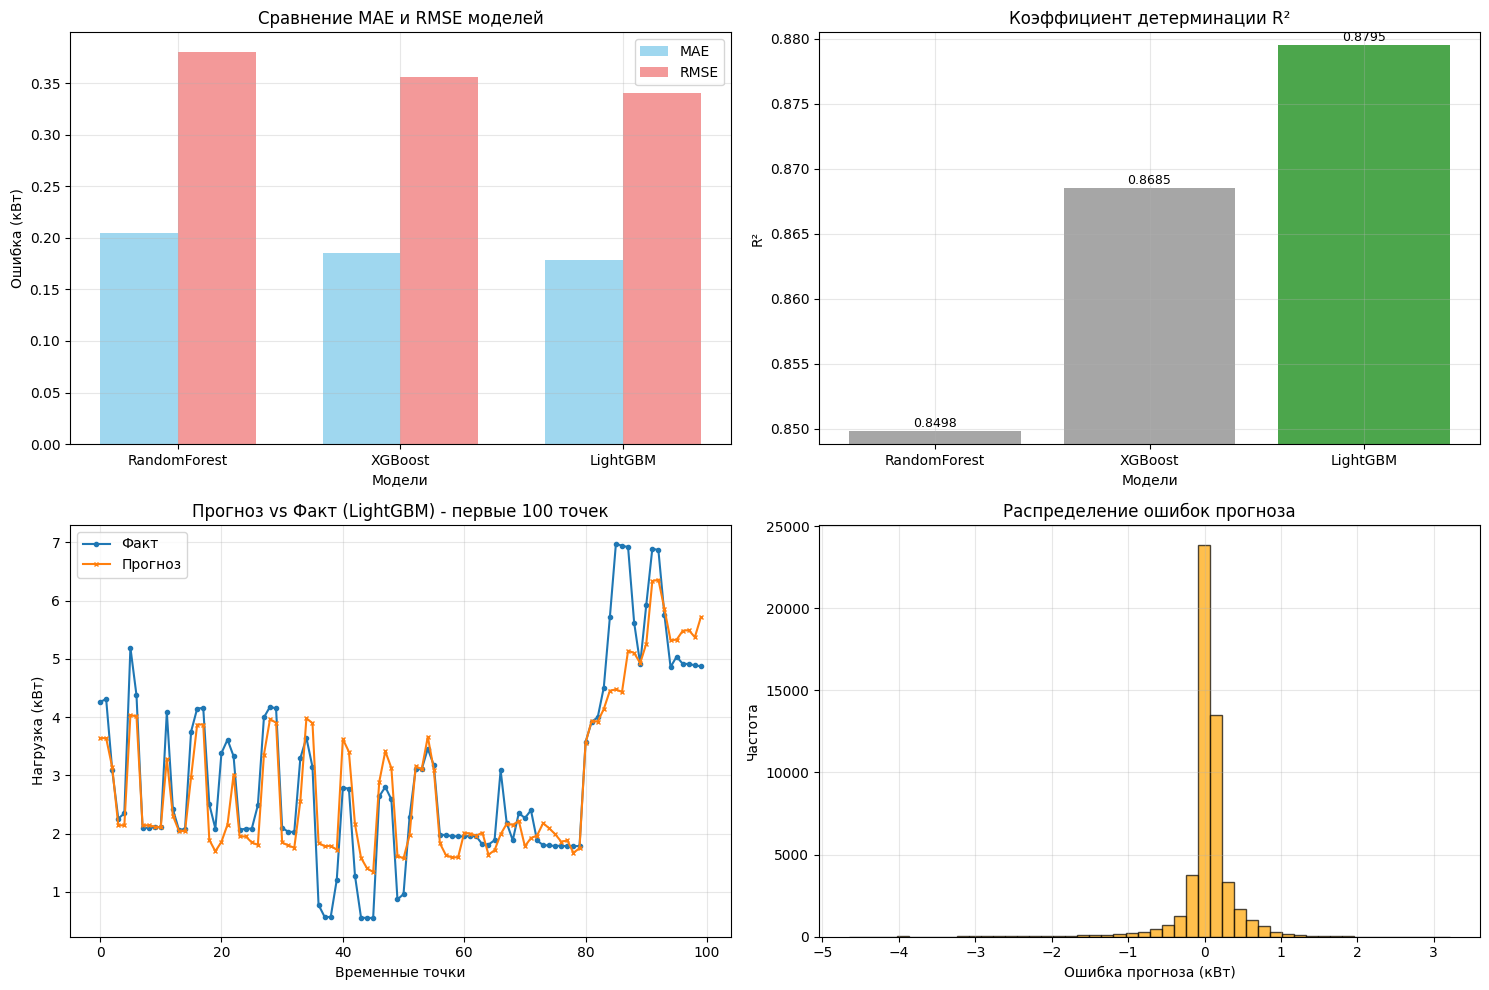


ТАБЛИЦА МЕТРИК:
Модель          MAE (кВт)    RMSE (кВт)   R²        
RandomForest    0.2050       0.3803       0.8498    
XGBoost         0.1853       0.3558       0.8685    
LightGBM        0.1783       0.3407       0.8795     

АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ (LightGBM):
• Средняя ошибка: 178.3 Вт
• Точность прогноза: 87.95%
• Максимальная ошибка: 4650.7 Вт


In [355]:
# ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ
print("\nОценка качества моделей на тестовой выборке:")

for name, model in models.items():
    # Прогнозы
    y_pred = model.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse, 
        'R2': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.4f} кВт")
    print(f"  RMSE: {rmse:.4f} кВт") 
    print(f"  R²:   {r2:.4f}")

# Сравнение моделей
print("\nСРАВНЕНИЕ МОДЕЛЕЙ:")
best_model = min(results, key=lambda x: results[x]['MAE'])
print(f"Лучшая модель по MAE: {best_model}")

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\nВизуализация результатов...")

# ГРАФИК СРАВНЕНИЯ МЕТРИК
plt.figure(figsize=(15, 10))

# График 1: Сравнение метрик
plt.subplot(2, 2, 1)
metrics = ['MAE', 'RMSE']
models_names = list(results.keys())
mae_values = [results[model]['MAE'] for model in models_names]
rmse_values = [results[model]['RMSE'] for model in models_names]

x = np.arange(len(models_names))
width = 0.35

plt.bar(x - width/2, mae_values, width, label='MAE', alpha=0.8, color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', alpha=0.8, color='lightcoral')

plt.xlabel('Модели')
plt.ylabel('Ошибка (кВт)')
plt.title('Сравнение MAE и RMSE моделей')
plt.xticks(x, models_names)
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: R² сравнение (ИСПРАВЛЕННЫЙ)
plt.subplot(2, 2, 2)
r2_values = [results[model]['R2'] for model in models_names]
colors = ['green' if model == best_model else 'gray' for model in models_names]

# Автоматически подбираем масштаб
r2_min, r2_max = min(r2_values), max(r2_values)
plt.ylim(r2_min - 0.001, r2_max + 0.001)  # Динамический масштаб

plt.bar(models_names, r2_values, color=colors, alpha=0.7)
plt.xlabel('Модели')
plt.ylabel('R²')
plt.title('Коэффициент детерминации R²')
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# График 3: Прогнозы vs Факт (для лучшей модели)
plt.subplot(2, 2, 3)
best_predictions = results[best_model]['predictions']

# Берем первые 100 точек для наглядности
sample_size = min(100, len(y_test))
plt.plot(y_test.values[:sample_size], label='Факт', marker='o', markersize=3)
plt.plot(best_predictions[:sample_size], label='Прогноз', marker='x', markersize=3)
plt.xlabel('Временные точки')
plt.ylabel('Нагрузка (кВт)')
plt.title(f'Прогноз vs Факт ({best_model}) - первые 100 точек')
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Ошибки прогноза
plt.subplot(2, 2, 4)
errors = best_predictions - y_test.values
plt.hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Ошибка прогноза (кВт)')
plt.ylabel('Частота')
plt.title('Распределение ошибок прогноза')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ТАБЛИЦА С МЕТРИКАМИ
print("\nТАБЛИЦА МЕТРИК:")
print("="*50)
print(f"{'Модель':<15} {'MAE (кВт)':<12} {'RMSE (кВт)':<12} {'R²':<10}")
print("="*50)
for model in models_names:
    mae = results[model]['MAE']
    rmse = results[model]['RMSE']
    r2 = results[model]['R2']
    marker = " " if model == best_model else ""
    print(f"{model:<15} {mae:<12.4f} {rmse:<12.4f} {r2:<10.4f}{marker}")
print("="*50)

# АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
print(f"\nАНАЛИЗ ЛУЧШЕЙ МОДЕЛИ ({best_model}):")
best_mae = results[best_model]['MAE']
best_rmse = results[best_model]['RMSE']
best_r2 = results[best_model]['R2']

print(f"• Средняя ошибка: {best_mae*1000:.1f} Вт")
print(f"• Точность прогноза: {best_r2*100:.2f}%")
print(f"• Максимальная ошибка: {np.max(np.abs(best_predictions - y_test.values))*1000:.1f} Вт")

ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
Модели обучены на 68 признаках

=== ПРОВЕРКА КОРРЕКТНОСТИ ДАННЫХ ===
RandomForest: сумма важностей = 100.0%
XGBoost: сумма важностей = 100.0%
LightGBM: сумма важностей = 100.0%

ТОП-15 самых важных признаков по версии LightGBM:
 1. rolling_mean_24h          13.90%
 2. ac_heating_ratio          9.93%
 3. kitchen_ratio             9.80%
 4. laundry_ratio             9.33%
 5. lag_same_day_24h          6.27%
 6. rolling_mean_168h         4.77%
 7. lag_96h_ago               3.57%
 8. hour_sin                  3.50%
 9. lag_72h_ago               3.07%
10. lag_48h_ago               2.87%
11. hour_cos                  2.83%
12. month_cos                 2.57%
13. lag_24h_winter            2.37%
14. lag_week_ago_168h         2.33%
15. lag_week_evening          1.83%


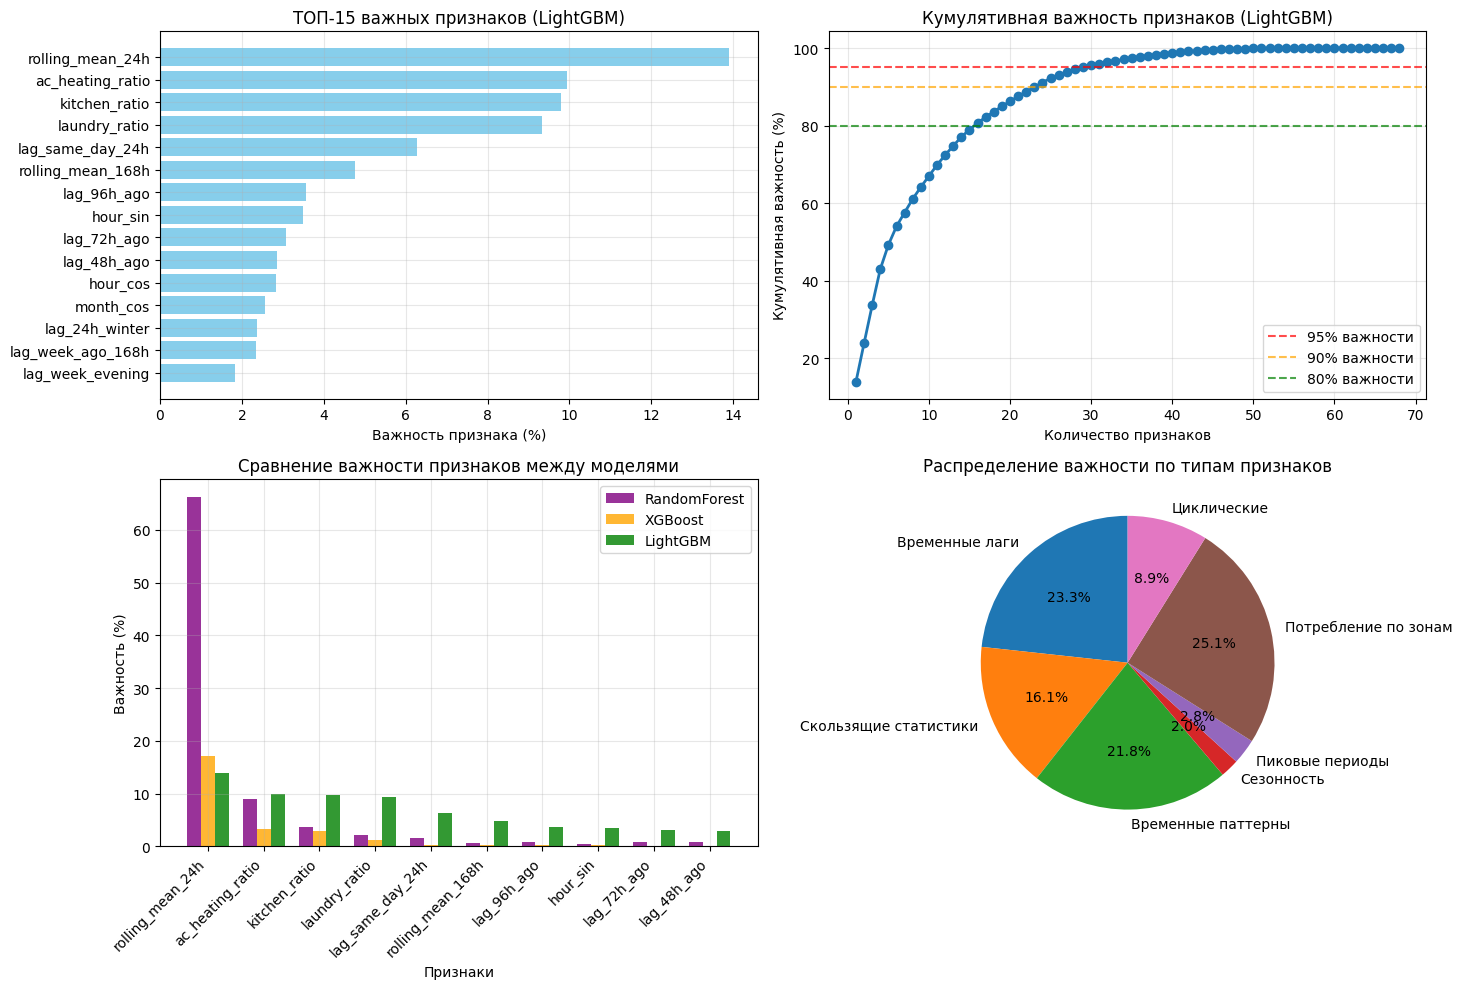


АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ
Признаков для 80% важности: 16
Признаков для 90% важности: 24
Признаков для 95% важности: 29
Всего признаков: 68

Самые важные признаки (топ-16):
   1. rolling_mean_24h          13.90%
   2. ac_heating_ratio          9.93%
   3. kitchen_ratio             9.80%
   4. laundry_ratio             9.33%
   5. lag_same_day_24h          6.27%
   6. rolling_mean_168h         4.77%
   7. lag_96h_ago               3.57%
   8. hour_sin                  3.50%
   9. lag_72h_ago               3.07%
  10. lag_48h_ago               2.87%
  11. hour_cos                  2.83%
  12. month_cos                 2.57%
  13. lag_24h_winter            2.37%
  14. lag_week_ago_168h         2.33%
  15. lag_week_evening          1.83%
  16. lag_24h_weekend           1.73%

АНАЛИЗ ДОМИНИРОВАНИЯ:
Самый важный признак: rolling_mean_24h (13.9%)
✅ ОТЛИЧНО: Сбалансированное распределение важности

ИНТЕРПРЕТАЦИЯ ЗАВЕРШЕНА!


In [356]:
# ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - ВАЖНОСТЬ ПРИЗНАКОВ (ИСПРАВЛЕННАЯ ВЕРСИЯ)
print("=" * 60)
print("ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("=" * 60)

# ВАЖНО: используем ТЕ ЖЕ признаки, что и при обучении моделей!
model_features = X_train.columns.tolist()
print(f"Модели обучены на {len(model_features)} признаках")

# Создаем DataFrame с важностью признаков для всех моделей
feature_importance_df = pd.DataFrame(index=model_features)

# Функция для нормализации важности признаков
def normalize_importance(importance_array):
    """Нормализует важность признаков к диапазону 0-100%"""
    if np.sum(importance_array) == 0:
        return importance_array
    return (importance_array / np.sum(importance_array)) * 100

# Для RandomForest
if hasattr(rf_model, 'feature_importances_'):
    if len(rf_model.feature_importances_) == len(model_features):
        feature_importance_df['RandomForest'] = normalize_importance(rf_model.feature_importances_)

# Для XGBoost - используем gain-based importance
if hasattr(xgb_model, 'get_booster'):
    try:
        xgb_importance = xgb_model.get_booster().get_score(importance_type='gain')
        # Преобразуем словарь в массив в правильном порядке
        xgb_importance_array = np.array([xgb_importance.get(f, 0) for f in model_features])
        feature_importance_df['XGBoost'] = normalize_importance(xgb_importance_array)
    except:
        # Fallback к стандартной важности
        if hasattr(xgb_model, 'feature_importances_'):
            feature_importance_df['XGBoost'] = normalize_importance(xgb_model.feature_importances_)

# Для LightGBM - используем gain-based importance
if hasattr(lgb_model, 'feature_importances_'):
    if len(lgb_model.feature_importances_) == len(model_features):
        feature_importance_df['LightGBM'] = normalize_importance(lgb_model.feature_importances_)

# Проверяем корректность данных
print("\n=== ПРОВЕРКА КОРРЕКТНОСТИ ДАННЫХ ===")
for model in feature_importance_df.columns:
    total_importance = feature_importance_df[model].sum()
    print(f"{model}: сумма важностей = {total_importance:.1f}%")
    
    if abs(total_importance - 100) > 1:  # Допуск 1%
        print(f"⚠️  {model}: возможна ошибка в расчетах!")

# Определяем модель для анализа
if best_model in feature_importance_df.columns:
    sort_column = best_model
elif 'LightGBM' in feature_importance_df.columns:
    sort_column = 'LightGBM'
elif 'XGBoost' in feature_importance_df.columns:
    sort_column = 'XGBoost'
else:
    sort_column = feature_importance_df.columns[0]

# Сортируем по важности
feature_importance_df = feature_importance_df.sort_values(sort_column, ascending=False)

print(f"\nТОП-15 самых важных признаков по версии {sort_column}:")
print("=" * 50)
for i, (feature, importance) in enumerate(feature_importance_df[sort_column].head(15).items()):
    print(f"{i+1:2d}. {feature:<25} {importance:.2f}%")

# ВИЗУАЛИЗАЦИЯ ВАЖНОСТИ ПРИЗНАКОВ
plt.figure(figsize=(15, 10))

# График 1: Важность признаков для лучшей модели
plt.subplot(2, 2, 1)
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features[sort_column], color='skyblue')
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Важность признака (%)')
plt.title(f'ТОП-15 важных признаков ({sort_column})')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

# График 2: Кумулятивная важность признаков
plt.subplot(2, 2, 2)
cumulative_importance = np.cumsum(feature_importance_df[sort_column])
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linewidth=2)
plt.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% важности')
plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% важности')
plt.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='80% важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность (%)')
plt.title(f'Кумулятивная важность признаков ({sort_column})')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Сравнение моделей (ТОП-10 признаков)
plt.subplot(2, 2, 3)
top_10_features = feature_importance_df.head(10)
x = np.arange(len(top_10_features))
width = 0.25

available_models = [col for col in ['RandomForest', 'XGBoost', 'LightGBM'] if col in feature_importance_df.columns]

if len(available_models) >= 2:
    colors = ['purple', 'orange', 'green']
    for i, model in enumerate(available_models):
        offset = width * (i - (len(available_models)-1)/2)
        plt.bar(x + offset, top_10_features[model], width, label=model, alpha=0.8, color=colors[i])
    
    plt.xlabel('Признаки')
    plt.ylabel('Важность (%)')
    plt.title('Сравнение важности признаков между моделями')
    plt.xticks(x, top_10_features.index, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Недостаточно данных\nдля сравнения моделей', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Сравнение важности признаков')

# График 4: Распределение по типам признаков
plt.subplot(2, 2, 4)
top_20_features = feature_importance_df.head(20)

# Классификация признаков
feature_categories = {
    'Временные лаги': [f for f in top_20_features.index if 'lag' in f],
    'Скользящие статистики': [f for f in top_20_features.index if 'rolling' in f or 'mean' in f or 'std' in f],
    'Временные паттерны': [f for f in top_20_features.index if 'hour' in f or 'day' in f or 'week' in f or 'month' in f],
    'Сезонность': [f for f in top_20_features.index if 'season' in f or 'spring' in f or 'winter' in f or 'summer' in f],
    'Пиковые периоды': [f for f in top_20_features.index if 'peak' in f or 'night' in f or 'morning' in f or 'evening' in f],
    'Потребление по зонам': [f for f in top_20_features.index if 'kitchen' in f or 'laundry' in f or 'ac_heating' in f],
    'Циклические': [f for f in top_20_features.index if 'sin' in f or 'cos' in f],
    'Другие': []
}

# Находим "Другие"
used_features = set()
for features in feature_categories.values():
    used_features.update(features)
feature_categories['Другие'] = [f for f in top_20_features.index if f not in used_features]

# Считаем важность по категориям
category_importance = {}
for category, features in feature_categories.items():
    if features:
        importance_sum = feature_importance_df.loc[features, sort_column].sum()
        if importance_sum > 0.1:  # Игнорируем очень маленькие значения
            category_importance[category] = importance_sum

if category_importance:
    plt.pie(category_importance.values(), labels=category_importance.keys(), autopct='%1.1f%%', startangle=90)
    plt.title('Распределение важности по типам признаков')
else:
    plt.text(0.5, 0.5, 'Нет данных для\nпостроения диаграммы', 
            ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ
print("\n" + "=" * 60)
print("АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ")
print("=" * 60)

# Находим количество признаков для разных уровней важности
n_features_80 = np.argmax(cumulative_importance >= 80) + 1 if any(cumulative_importance >= 80) else len(cumulative_importance)
n_features_90 = np.argmax(cumulative_importance >= 90) + 1 if any(cumulative_importance >= 90) else len(cumulative_importance)
n_features_95 = np.argmax(cumulative_importance >= 95) + 1 if any(cumulative_importance >= 95) else len(cumulative_importance)

print(f"Признаков для 80% важности: {n_features_80}")
print(f"Признаков для 90% важности: {n_features_90}") 
print(f"Признаков для 95% важности: {n_features_95}")
print(f"Всего признаков: {len(feature_importance_df)}")

print(f"\nСамые важные признаки (топ-{n_features_80}):")
critical_features = feature_importance_df.head(n_features_80).index.tolist()
for i, feature in enumerate(critical_features, 1):
    importance = feature_importance_df.loc[feature, sort_column]
    print(f"  {i:2d}. {feature:<25} {importance:.2f}%")

# Анализ доминирования
top_feature_importance = feature_importance_df[sort_column].iloc[0]
print(f"\nАНАЛИЗ ДОМИНИРОВАНИЯ:")
print(f"Самый важный признак: {feature_importance_df.index[0]} ({top_feature_importance:.1f}%)")

if top_feature_importance > 50:
    print("🔴 КРИТИЧЕСКОЕ ДОМИНИРОВАНИЕ: Один признак >50%")
    print("   Рекомендуется исключить этот признак или ослабить его влияние")
elif top_feature_importance > 30:
    print("🟡 УМЕРЕННОЕ ДОМИНИРОВАНИЕ: Один признак 30-50%")
    print("   Рассмотреть возможность балансировки признаков")
elif top_feature_importance > 20:
    print("🟢 НОРМА: Самый важный признак 20-30%")
else:
    print("✅ ОТЛИЧНО: Сбалансированное распределение важности")

print(f"\nИНТЕРПРЕТАЦИЯ ЗАВЕРШЕНА!")


АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ
Большие ошибки (> 0.05 кВт): 34865 (66.88%)

Характеристики периодов с большими ошибками:
Час дня:
hour
0     1481
1     1113
2     1003
3      940
4     1025
5     1057
6     1660
7     1846
8     1561
9     1510
10    1481
11    1465
12    1428
13    1371
14    1220
15    1219
16    1315
17    1300
18    1526
19    1890
20    1956
21    1943
22    1865
23    1690
Name: count, dtype: int64

День недели:
  Пн: 4651 ошибок
  Вт: 4865 ошибок
  Ср: 4972 ошибок
  Чт: 4233 ошибок
  Пт: 4929 ошибок
  Сб: 5755 ошибок
  Вс: 5460 ошибок

Пиковые периоды:
  Вечерний пик: 9180 ошибок
  Утренний пик: 4917 ошибок
  Ночное время: 6619 ошибок


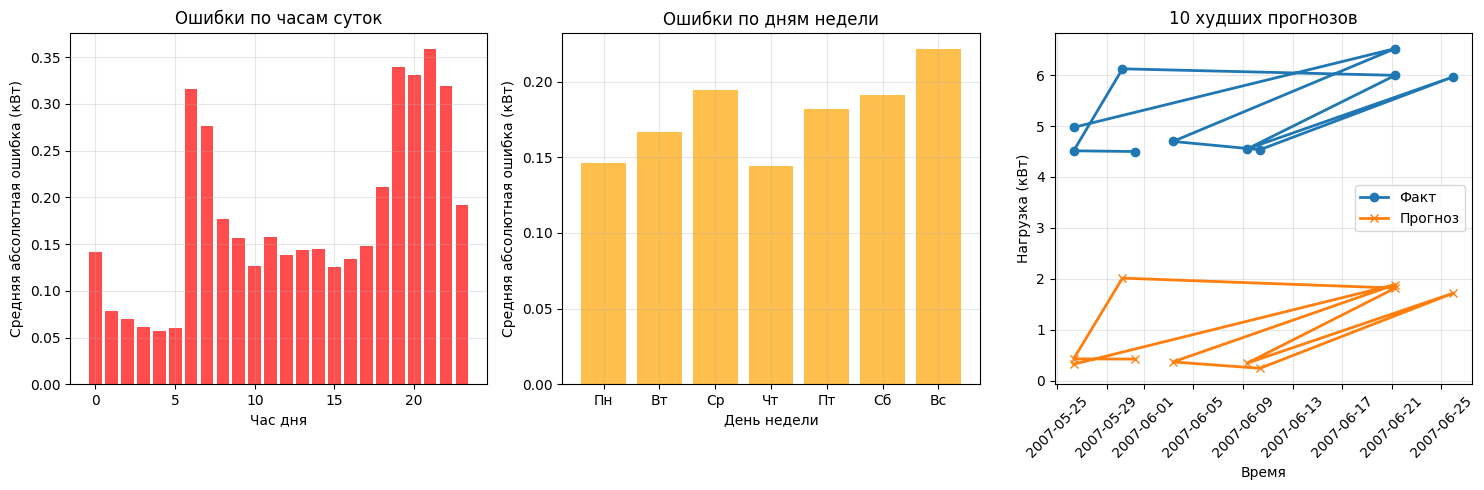

In [357]:
# АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ
print("\n" + "=" * 60)
print("АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ")
print("=" * 60)

# Берем прогнозы лучшей модели
y_pred_best = results[f'{best_model}']['predictions']  # Теперь лучшая модель RandomForest!
errors = y_pred_best - y_test.values

# Создаем Series с ошибками и правильными индексами
errors_series = pd.Series(errors, index=y_test.index)

# Анализ больших ошибок
error_threshold = 0.05  # 50 Вт - порог для "большой" ошибки
large_errors_mask = np.abs(errors) > error_threshold
large_errors_count = np.sum(large_errors_mask)
large_errors_percentage = (large_errors_count / len(errors)) * 100

print(f"Большие ошибки (> {error_threshold} кВт): {large_errors_count} ({large_errors_percentage:.2f}%)")

if large_errors_count > 0:
    # Анализ когда происходят большие ошибки
    large_errors_data = X_test[large_errors_mask]
    
    print("\nХарактеристики периодов с большими ошибками:")
    print("Час дня:")
    print(large_errors_data['hour'].value_counts().sort_index())
    
    print("\nДень недели:")
    day_names = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
    day_counts = large_errors_data['day_of_week'].value_counts().sort_index()
    for day, count in day_counts.items():
        print(f"  {day_names[day]}: {count} ошибок")
    
    print(f"\nПиковые периоды:")
    print(f"  Вечерний пик: {large_errors_data['is_evening_peak'].sum()} ошибок")
    print(f"  Утренний пик: {large_errors_data['is_morning_peak'].sum()} ошибок")
    print(f"  Ночное время: {large_errors_data['is_night'].sum()} ошибок")

# ВИЗУАЛИЗАЦИЯ ОШИБОК
plt.figure(figsize=(15, 5))

# График 1: Распределение ошибок по времени суток
plt.subplot(1, 3, 1)
# ИСПРАВЛЕНИЕ: убираем ['Global_active_power'] - его нет в X_test
hourly_errors = X_test.groupby('hour').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(hourly_errors.index, hourly_errors.values, alpha=0.7, color='red')
plt.xlabel('Час дня')
plt.ylabel('Средняя абсолютная ошибка (кВт)')
plt.title('Ошибки по часам суток')
plt.grid(True, alpha=0.3)

# График 2: Ошибки по дням недели  
plt.subplot(1, 3, 2)
# ИСПРАВЛЕНИЕ: убираем ['Global_active_power']
daily_errors = X_test.groupby('day_of_week').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(daily_errors.index, daily_errors.values, alpha=0.7, color='orange')
plt.xlabel('День недели')
plt.ylabel('Средняя абсолютная ошибка (кВт)')
plt.title('Ошибки по дням недели')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True, alpha=0.3)

# График 3: Факт vs Прогноз для худших случаев
plt.subplot(1, 3, 3)
worst_indices = np.argsort(np.abs(errors))[-10:]  # 10 худших прогнозов
worst_times = y_test.iloc[worst_indices].index

plt.plot(worst_times, y_test.iloc[worst_indices], 'o-', label='Факт', linewidth=2)
plt.plot(worst_times, y_pred_best[worst_indices], 'x-', label='Прогноз', linewidth=2)
plt.xlabel('Время')
plt.ylabel('Нагрузка (кВт)')
plt.title('10 худших прогнозов')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [358]:
# СОХРАНЕНИЕ ТОЛЬКО ЛУЧШЕЙ МОДЕЛИ
print("Сохранение только лучшей модели...")

# Сохраняем только лучшую модель
best_model_name = best_model
best_model_obj = models[best_model_name]

filename = f'models/best_model_{best_model_name.lower()}.pkl'
joblib.dump(best_model_obj, filename)
print(f"✅ Лучшая модель сохранена: {best_model_name} -> {filename}")

# Сохраняем метрики всех моделей для сравнения
results_df = pd.DataFrame(results).T
results_df.to_csv('models/all_models_metrics.csv')
print("📊 Метрики всех моделей сохранены для сравнения")

# Сохраняем информацию о лучшей модели отдельно
best_model_info = {
    'model_name': best_model_name,
    'mae': results[best_model_name]['MAE'],
    'rmse': results[best_model_name]['RMSE'], 
    'r2': results[best_model_name]['R2'],
    'features_count': X_train.shape[1],
    'train_size': X_train.shape[0],
    'test_size': X_test.shape[0],
    'train_period': f"{X_train.index.min()} - {X_train.index.max()}",
    'test_period': f"{X_test.index.min()} - {X_test.index.max()}"
}

with open('models/best_model_info.json', 'w', encoding='utf-8') as f:
    json.dump(best_model_info, f, ensure_ascii=False, indent=2)
print("📋 Информация о лучшей модели сохранена")

# Сохраняем имена признаков для будущего использования
feature_names = X_train.columns.tolist()
with open('models/feature_names.json', 'w', encoding='utf-8') as f:
    json.dump(feature_names, f, ensure_ascii=False, indent=2)
print(f"🔧 Сохранены имена {len(feature_names)} признаков")

print(f"\n🎯 ИТОГОВЫЙ РЕЗУЛЬТАТ:")
print(f"   Лучшая модель: {best_model_name}")
print(f"   MAE: {results[best_model_name]['MAE']:.4f} кВт ({results[best_model_name]['MAE']*1000:.1f} Вт)")
print(f"   R²: {results[best_model_name]['R2']:.4f} ({results[best_model_name]['R2']*100:.2f}%)")
print(f"   Количество признаков: {X_train.shape[1]}")
print(f"   Размер обучающей выборки: {X_train.shape[0]:,} записей")
print(f"   Период обучения: {X_train.index.min().strftime('%d.%m.%Y')} - {X_train.index.max().strftime('%d.%m.%Y')}")

Сохранение только лучшей модели...
✅ Лучшая модель сохранена: LightGBM -> models/best_model_lightgbm.pkl
📊 Метрики всех моделей сохранены для сравнения
📋 Информация о лучшей модели сохранена
🔧 Сохранены имена 68 признаков

🎯 ИТОГОВЫЙ РЕЗУЛЬТАТ:
   Лучшая модель: LightGBM
   MAE: 0.1783 кВт (178.3 Вт)
   R²: 0.8795 (87.95%)
   Количество признаков: 68
   Размер обучающей выборки: 208,512 записей
   Период обучения: 01.01.2007 - 25.05.2007
